In [13]:
import numpy as np # linear algebra
import pandas as pd 
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
import shutil
import cv2
import pydicom
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
from IPython.display import HTML
import gdcm
import os
import numpy

In [14]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std

    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)

    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    # Threshold the image and the output will be a binary image. Morphology workes either on binary or gray images.
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [17]:
def plot_stack(stack, start_with=10, show_every=3):
    size = (len(stack) - (start_with - 1))//show_every
    rows, cols = get_rows_cols(size)
    plt.tight_layout()
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(size-1):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [15]:
import nrrd

filename = '/Users/salma/Downloads/CT/Class 0/R01-117_CT.nrrd'

# Read the data back from file
readdata, header = nrrd.read(filename)

In [ ]:
masked_lung = []

for img in image:
    print(img)
    masked_lung.append(make_lungmask(img))
    
plot_stack(masked_lung, start_with=0, show_every=1)

In [25]:
import pydicom
file_path = "./image.0032.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)
image = medical_image.pixel_array

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 258
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.27396254576503088903693864162922465
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.22.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.22'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.4.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.27396254576503088903693864162

In [2]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
    
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [11]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    # hu_image = transform_to_hu(medical_image, image)
    hu_image = image
    brain_image = window_image(hu_image, 40, 80) #bone windowing
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image

In [ ]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

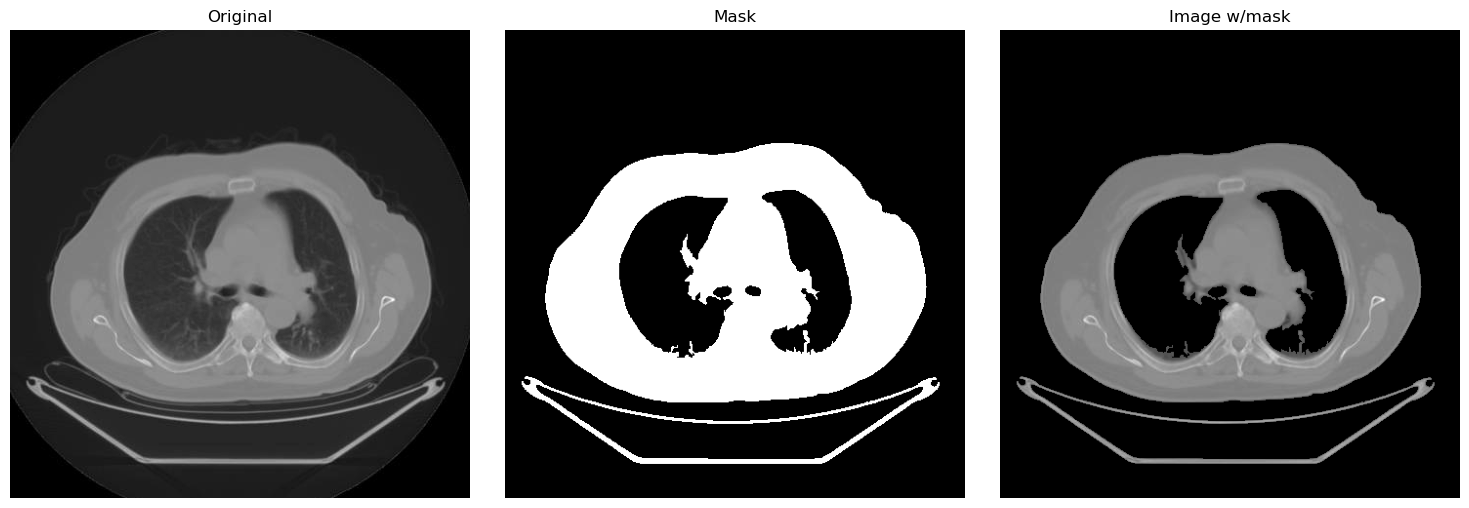

In [35]:
from skimage import io, filters, color, morphology
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = "./newpics/test/Class 0/R01-017_CT_88.jpg"
loaded_image = io.imread(image_path)

# Crop the image if necessary (assuming the loaded image has at least one color channel)
cropped_image = loaded_image[9:-23, 32:-9]

# Check if the image has three channels (indicating it's in color)
if cropped_image.ndim == 3 and cropped_image.shape[2] == 3:
    # Convert color image to grayscale
    gray = color.rgb2gray(cropped_image)
elif cropped_image.ndim == 2:  # Image is already grayscale
    gray = cropped_image
else:
    raise ValueError("The image is neither grayscale nor RGB.")

# Continue with the rest of your code...
# Apply threshold to create binary mask
tgray = gray > filters.threshold_otsu(gray)

# Remove small objects and holes
keep_mask = morphology.remove_small_objects(tgray, min_size=463)
keep_mask = morphology.remove_small_holes(keep_mask)
#invert mask
#keep_mask = np.invert(keep_mask)
# If the original image was RGB, we use the mask to create a masked RGB image.
# If the original image was grayscale, we just use the grayscale mask.
if cropped_image.ndim == 3:
    # Apply mask to original RGB image
    masked_img = np.einsum('ijk,ij->ijk', cropped_image, keep_mask)
else:
    # Apply mask to grayscale image
    masked_img = gray * keep_mask

# Plotting
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))  # Increase figure size for better visibility
image_list = [cropped_image, keep_mask, masked_img]
title_list = ["Original", "Mask", "Image w/mask"]

for i, ax in enumerate(axes):
    # Check if grayscale for display purposes
    cmap = 'gray' if image_list[i].ndim == 2 else None
    ax.imshow(image_list[i], cmap=cmap)
    ax.set_title(title_list[i])
    ax.axis("off")

fig.tight_layout()
plt.show()


In [2]:
from lungmask import LMInferer
import SimpleITK as sitk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2  
from tqdm import tqdm
import nrrd
from keras.preprocessing.image import load_img, img_to_array

lungmask 2023-11-13 15:32:08 No GPU found, using CPU instead


python(15171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
7it [01:32, 13.20s/it]                         

lungmask 2023-11-13 15:33:41 Postprocessing



100%|██████████| 29/29 [00:00<00:00, 71.45it/s]


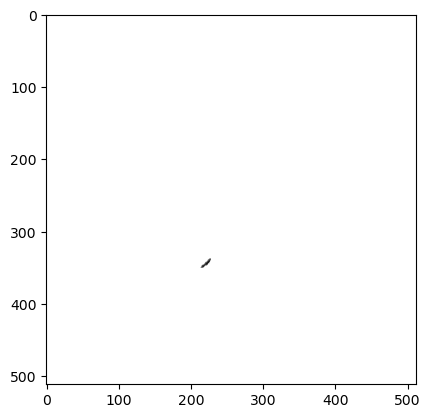

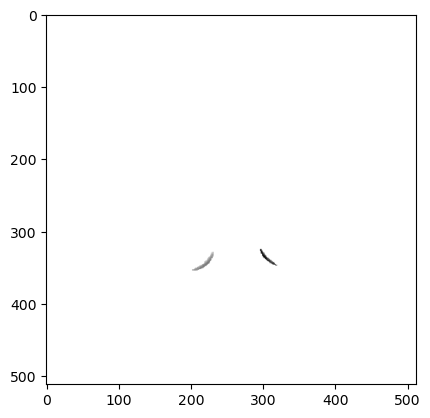

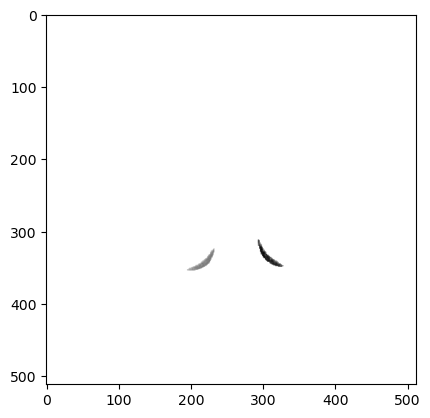

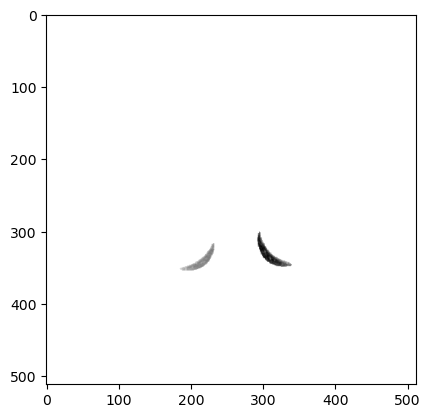

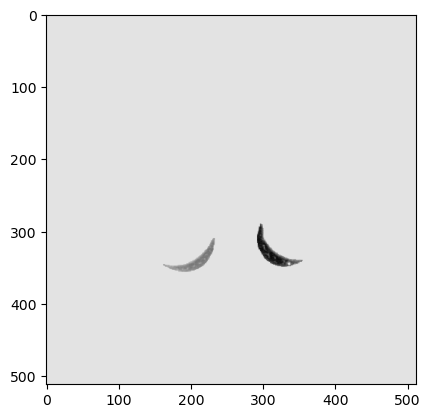

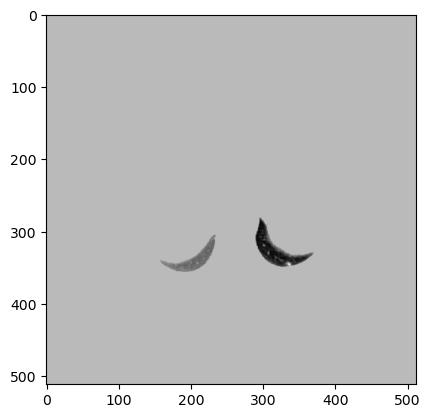

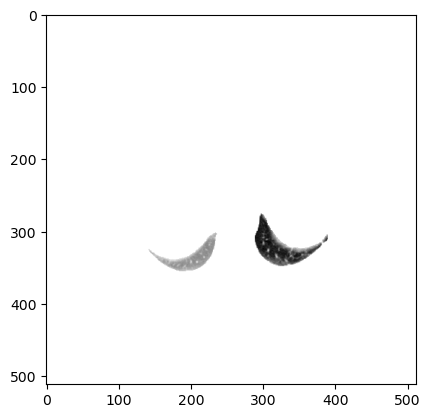

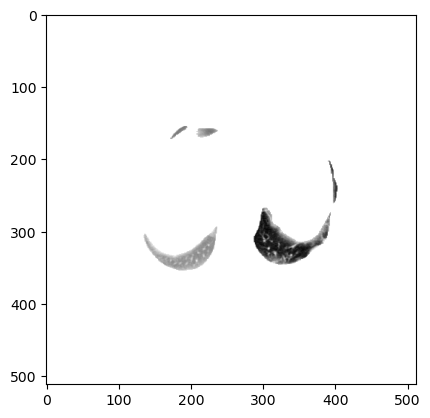

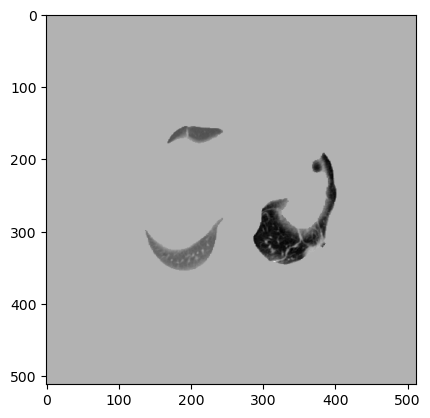

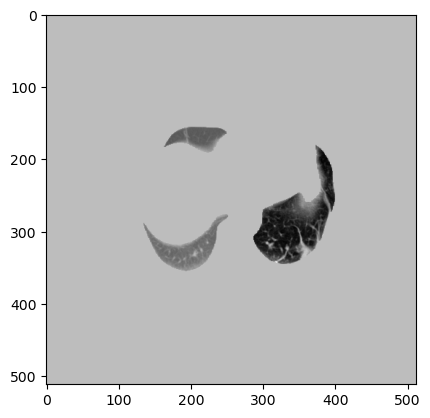

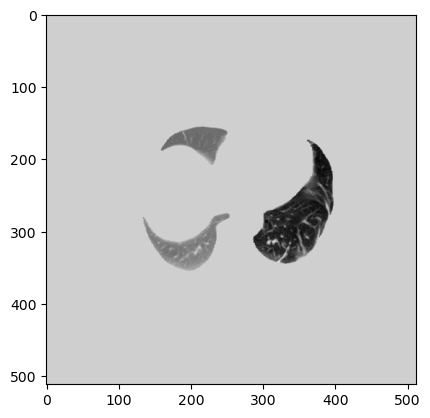

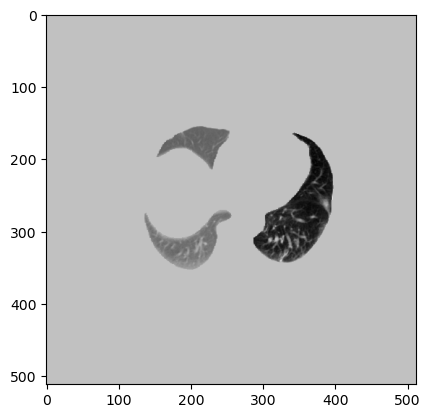

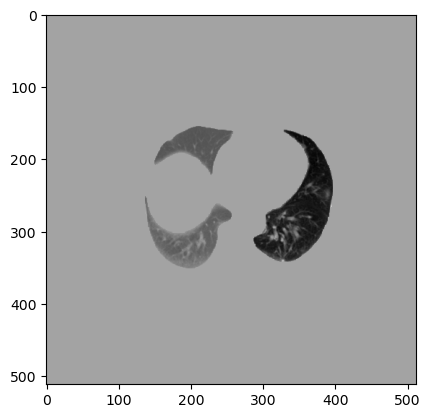

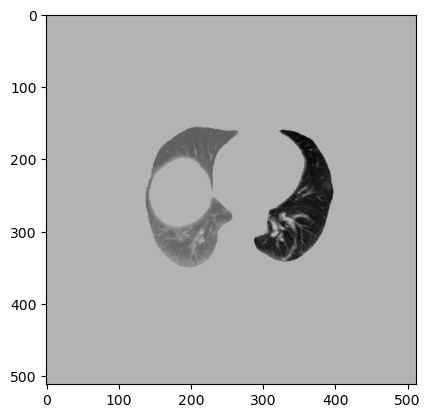

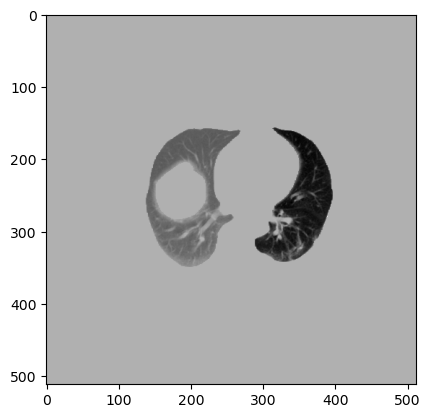

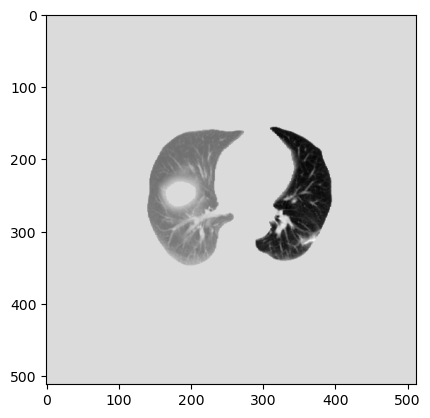

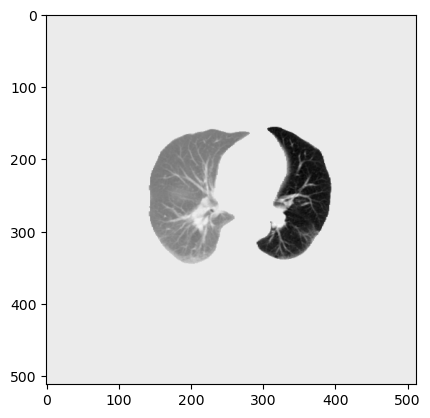

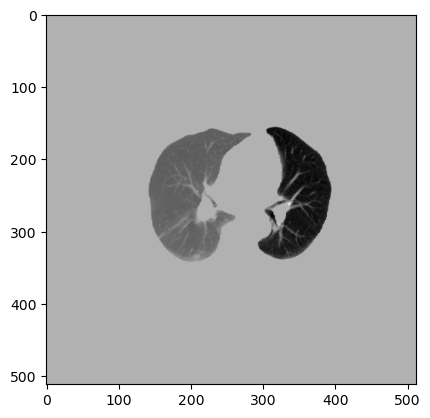

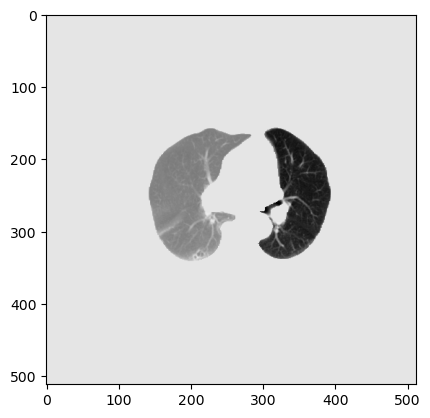

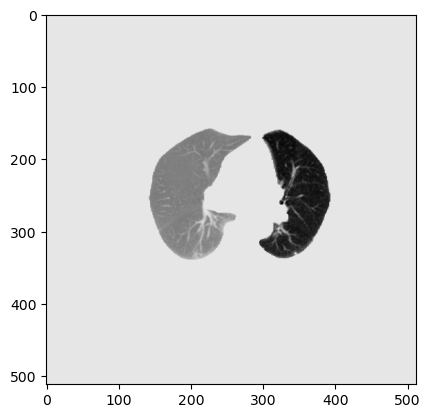

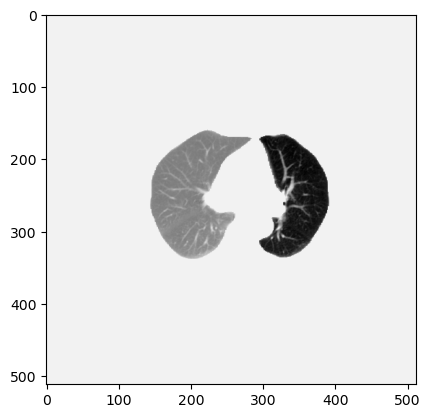

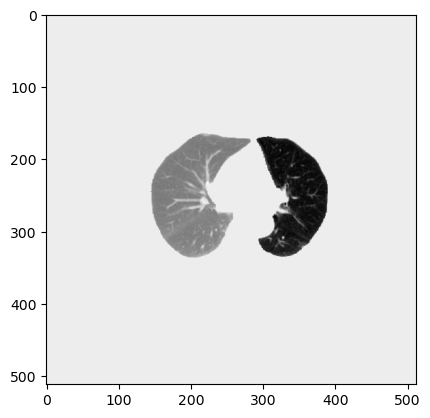

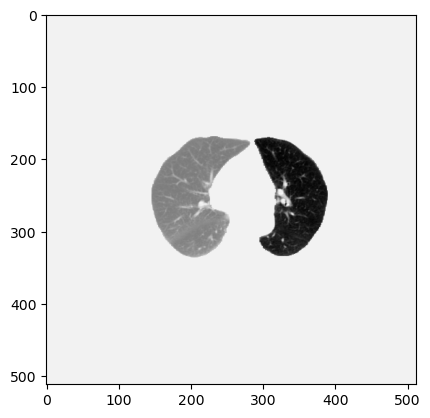

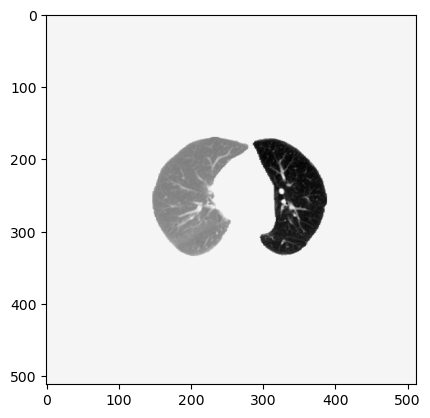

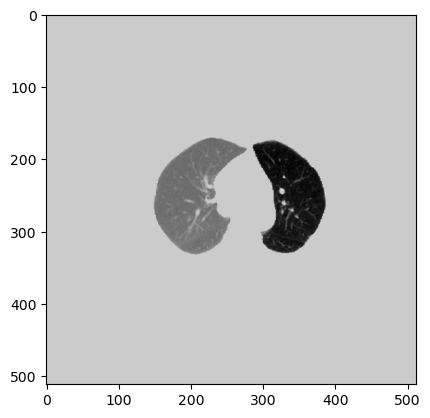

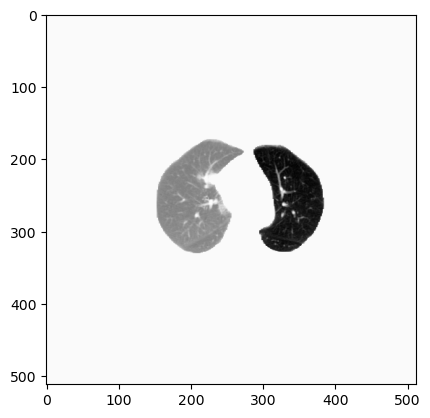

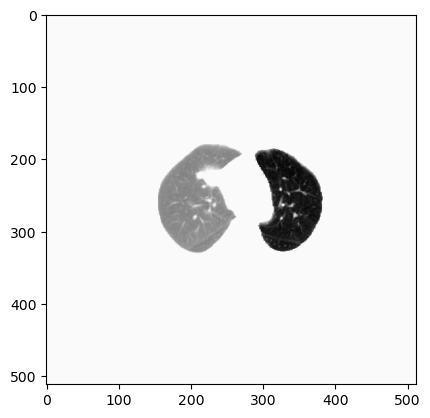

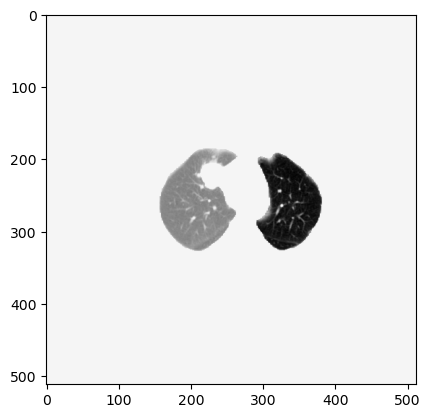

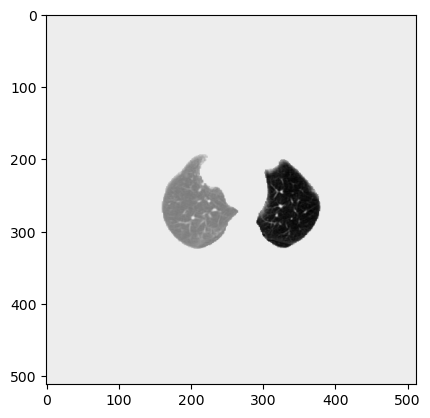

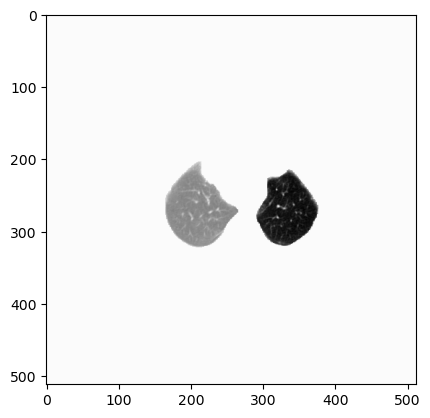

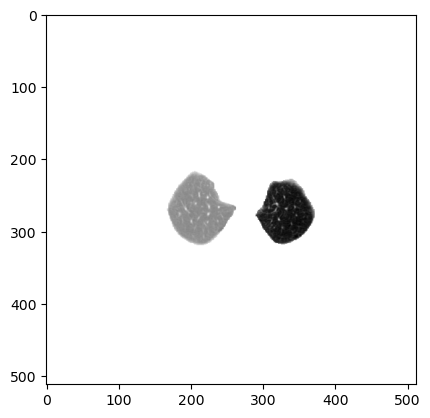

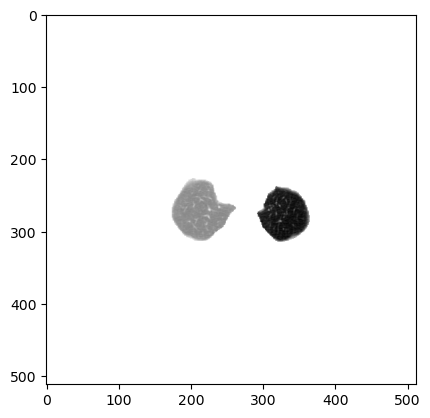

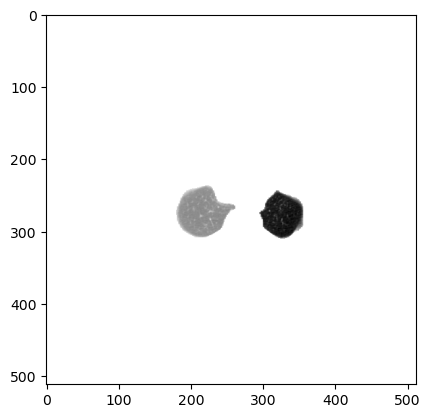

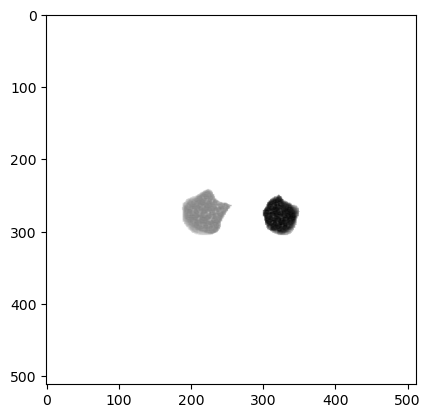

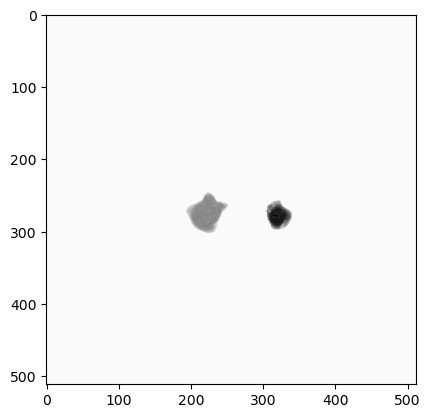

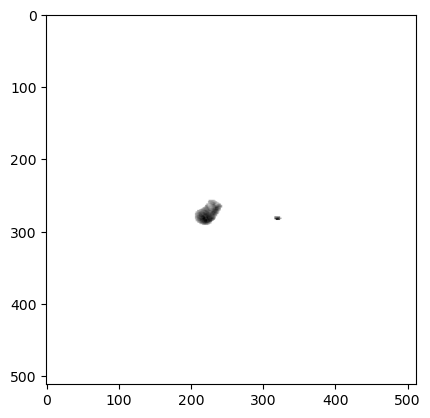

In [4]:
volume_path = f'/Users/salma/Downloads/NRRD Dataset/R01-027/R01-027_CT.nrrd'
image = sitk.ReadImage(volume_path)
original_spacing = image.GetSpacing()
original_size = image.GetSize()
new_spacing = (original_spacing[0], original_spacing[1], (original_spacing[2]*original_size[2])/128.0)
new_size = (original_size[0], original_size[1], 128)
resampled_image = sitk.Resample(image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), new_spacing, image.GetDirection())
image_array = sitk.GetArrayFromImage(resampled_image)

inferer = LMInferer()
segmentation = inferer.apply(image_array)  # default model is U-net(R231)

for frame in range(min(segmentation.shape[0], image.GetSize()[2])):
    pixel_count = segmentation[frame].sum()
    if pixel_count > np.mean(segmentation):
        masked = image_array[frame] * segmentation[frame]
        plt.imshow(masked, cmap='gray')
        plt.show()
        # b = np.asarray(image_array[frame]).astype(int)
        # cv2.imwrite(f'./Lung Img/{p}/{p}_{frame}_CT.jpg', manipulating_nrrd_contrast(b,128))

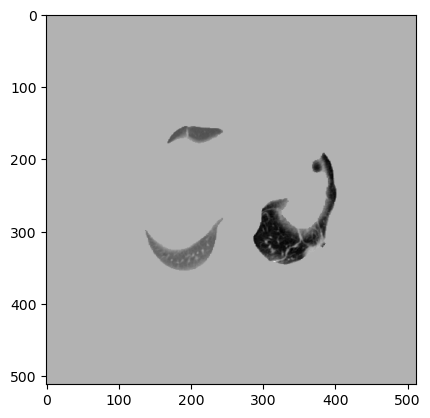

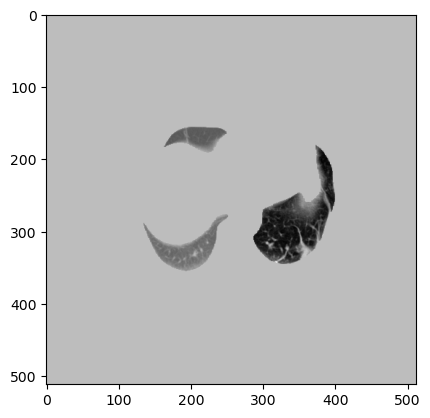

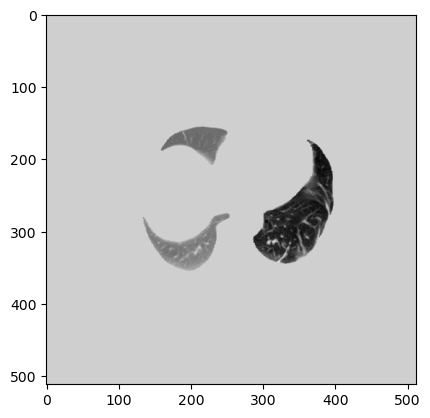

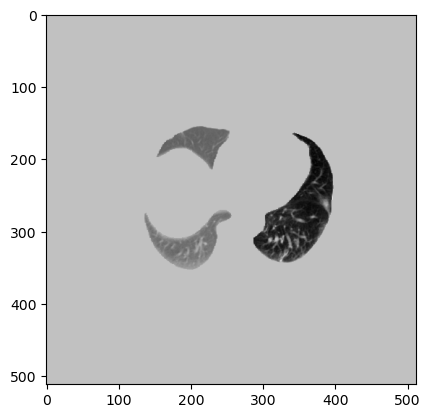

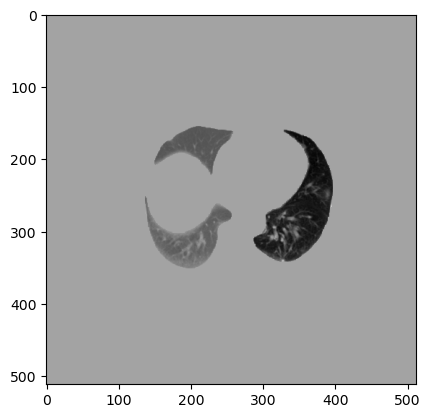

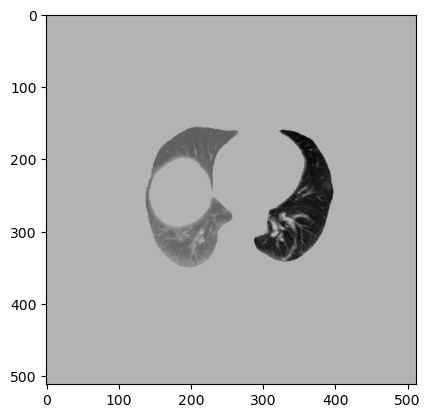

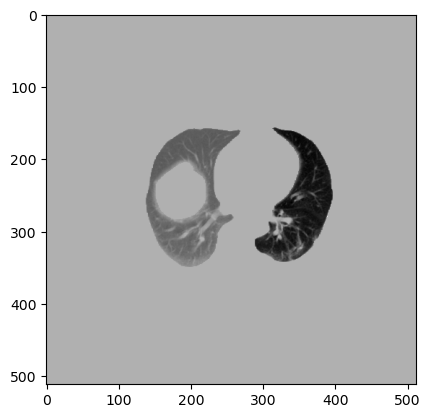

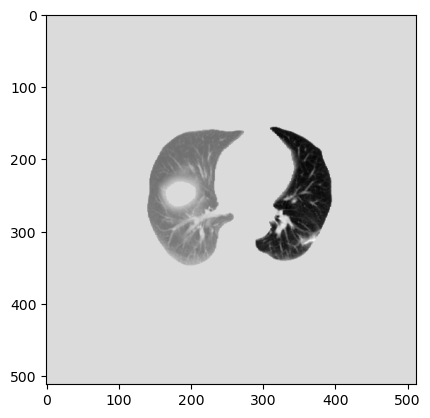

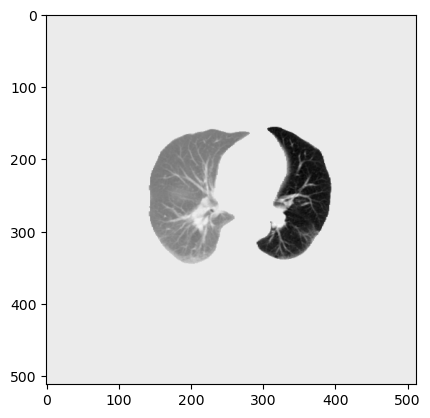

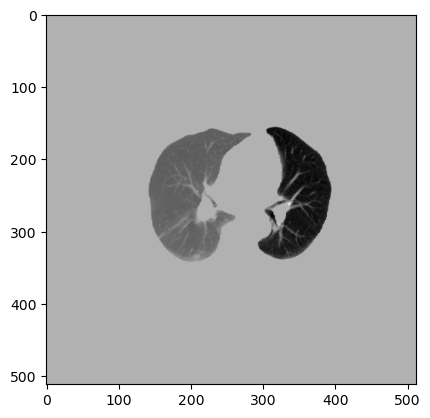

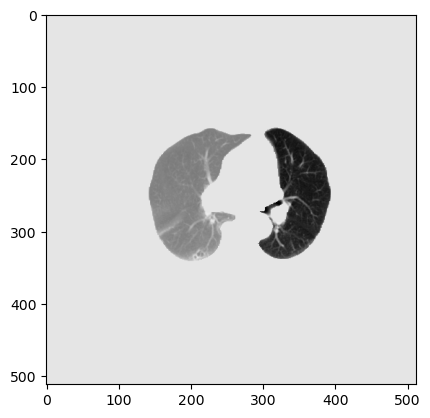

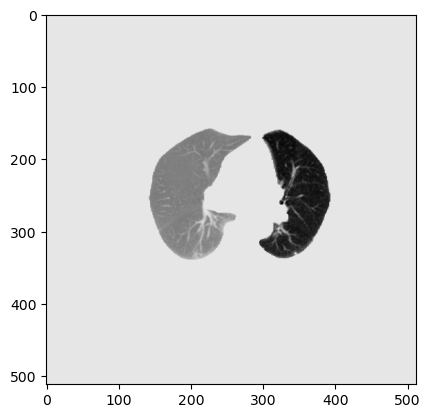

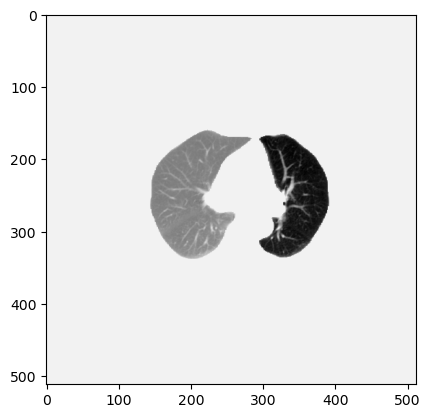

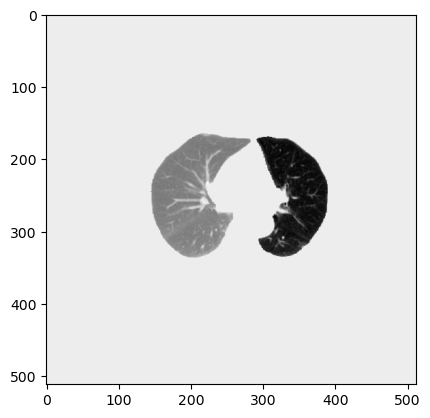

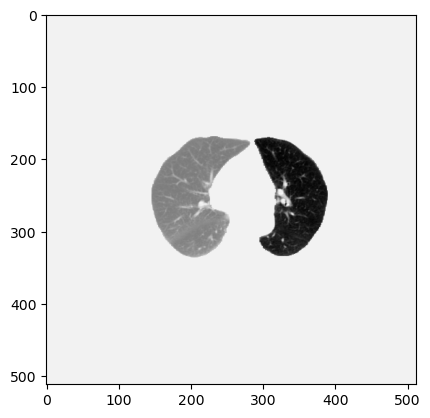

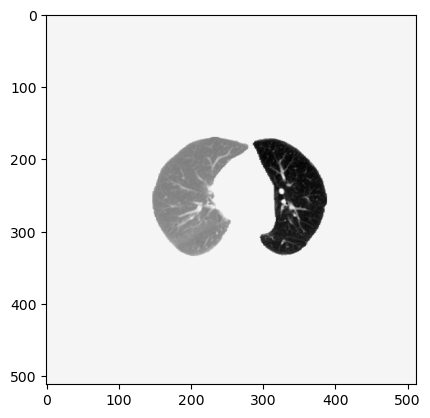

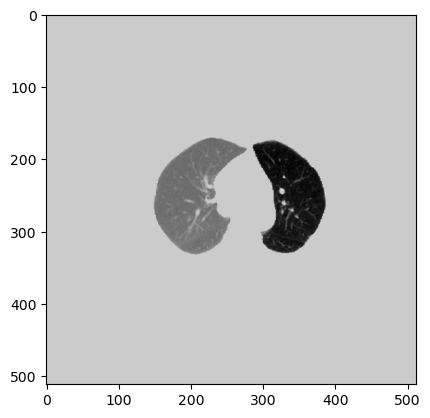

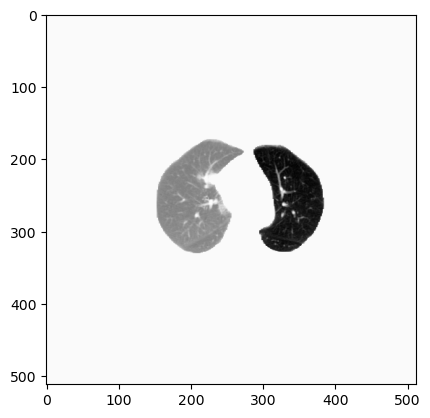

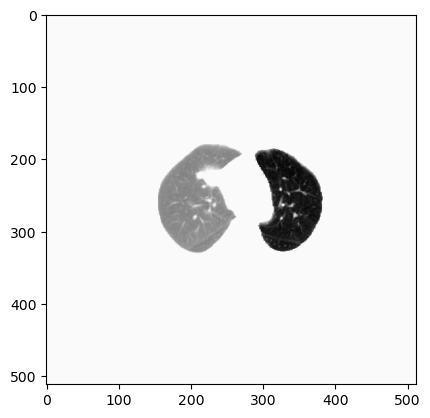

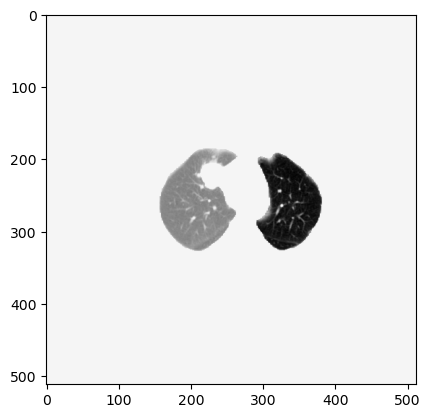

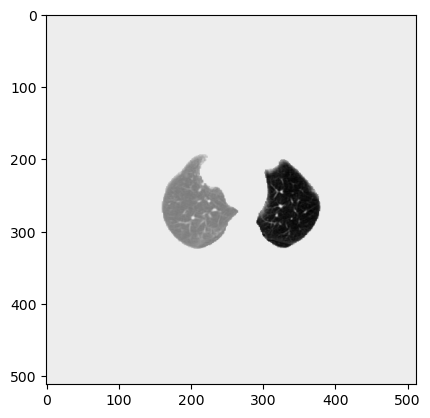

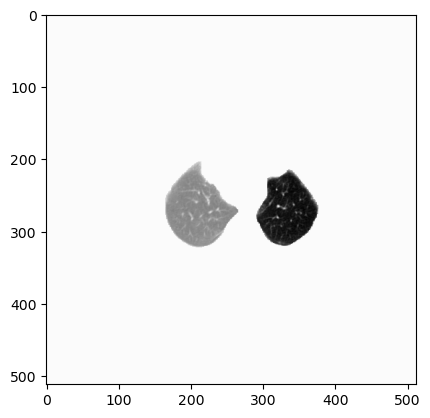

In [5]:
for frame in range(min(segmentation.shape[0], image.GetSize()[2])):
    pixel_count = segmentation[frame].sum()
    if pixel_count > 17000:
        masked = image_array[frame] * segmentation[frame]
        plt.imshow(masked, cmap='gray')
        plt.show()
        # b = np.asarray(image_array[frame]).astype(int)
        # cv2.imwrite(f'./Lung Img/{p}/{p}_{frame}_CT.jpg', manipulating_nrrd_contrast(b,128))

In [42]:
def manipulating_nrrd_contrast(img, level):
    img_c = img.astype(int).copy()
    factor = (8 * (level+255)) / (255 * (259-level)) 
    img_c = factor * (img_c - 128) + 128
    img_c = np.clip(img_c, 0, 255)
    return img_c.astype(np.uint8)